In [1]:
%load_ext autoreload
%autoreload 2

In [131]:
import os
import shutil
from itertools import product
import json
import yaml
import intake
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import funnel
import data_collections as dc
import operators as ops
import util


import traits_db
import metabolic as mi

Modify `groupby_attrs` to remove `member_id` so that that ends up as a dimension in the datasets.

In [47]:
df = mi.open_traits_df()
df

,Species,alphaD_log10,Emet,Eo,Ao,Ac,Phi_crit
0,Acanthephyra acutifrons,0.479565,0.040200,-0.027836,0.264715,0.131959,2.006040
1,Acanthephyra curtirostris,0.377714,0.043938,0.038027,0.252578,0.141861,1.780456
2,Acanthephyra purpurea,1.035748,0.840722,0.131972,0.230068,0.073638,3.124330
3,Acanthephyra smithi,1.082577,0.313173,-0.030067,0.286307,0.174423,1.641453
4,Acipenser brevirostrum,NaN,NaN,0.362569,0.218524,0.048415,4.513525
...,...,...,...,...,...,...,...
56,Styela plicata,0.433791,0.346635,-0.190998,0.061336,0.043505,1.409863
57,Systellaspis debilis,0.779626,0.418652,0.226970,0.219289,0.096003,2.284196
58,Tarletonbeania crenularis,NaN,NaN,0.213307,0.203696,0.051780,3.933876
59,Tautogolabrus adspersus,0.801974,0.327012,0.244520,0.170886,0.051204,3.337395


array([0.03, 0.05, 0.09, 0.16, 0.3 , 0.55])

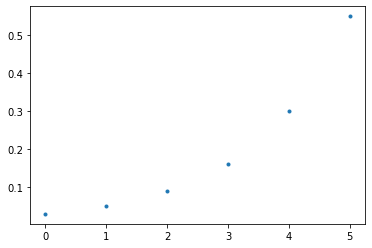

In [91]:
log10_values = np.log10(df.Ac.values)
Ac_coord = np.round(np.logspace(log10_values.min(), log10_values.max(), 6), 4)
plt.plot(Ac_coord, '.');
Ac_coord

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

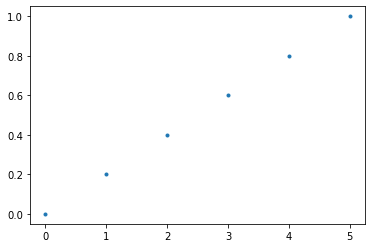

In [92]:
Eo_coord = np.round(np.linspace(0, 1., 6), 4)
plt.plot(Eo_coord, '.');
Eo_coord

In [114]:
trait_axis = [(Eo, Ac) for Eo, Ac in product(Eo_coord, Ac_coord)]
trait_axis

[(0.0, 0.03),
 (0.0, 0.05),
 (0.0, 0.09),
 (0.0, 0.16),
 (0.0, 0.3),
 (0.0, 0.55),
 (0.2, 0.03),
 (0.2, 0.05),
 (0.2, 0.09),
 (0.2, 0.16),
 (0.2, 0.3),
 (0.2, 0.55),
 (0.4, 0.03),
 (0.4, 0.05),
 (0.4, 0.09),
 (0.4, 0.16),
 (0.4, 0.3),
 (0.4, 0.55),
 (0.6, 0.03),
 (0.6, 0.05),
 (0.6, 0.09),
 (0.6, 0.16),
 (0.6, 0.3),
 (0.6, 0.55),
 (0.8, 0.03),
 (0.8, 0.05),
 (0.8, 0.09),
 (0.8, 0.16),
 (0.8, 0.3),
 (0.8, 0.55),
 (1.0, 0.03),
 (1.0, 0.05),
 (1.0, 0.09),
 (1.0, 0.16),
 (1.0, 0.3),
 (1.0, 0.55)]

In [96]:
dEodT_bar = -0.0226
dEodT_bar

-0.0226

In [84]:
catalog_json_file = funnel.to_intake_esm(agg_member_id=True)

sub_spec = dict(
    name='drift-corrected',
    experiment=['20C', 'RCP85'],
    member_id=dc.ocean_bgc_member_ids[1:],
)

catalog = funnel.to_intake_esm(agg_member_id=True).search(**sub_spec)
catalog

,unique
experiment,2
component,1
stream,1
member_id,33
variable,6
name,1
path,350


In [86]:
catalog.search(experiment='20C', variable=['pO2', 'TEMP'], member_id=10).df

,experiment,component,stream,member_id,variable,name,path
0,20C,ocn,pop.h,10,TEMP,drift-corrected,/glade/scratch/mclong/ocean-metabolism/funnel-...
1,20C,ocn,pop.h,10,pO2,drift-corrected,/glade/scratch/mclong/ocean-metabolism/funnel-...


In [128]:
cache_dir = '/glade/scratch/mclong/ocean-metabolism/funnel-cache'

def _gen_cache_file_name(experiment, component, stream, member_id, variable, additional_coord_values_str):
    additional_coord_values_str = '_'.join([f'{k}={v:0.4f}' for k, v in additional_coord_values.items()])
    return f'{cache_dir}/glade-cesm1-le.{experiment}.{component}.{stream}.{int(member_id):03d}.{variable}_{additional_coord_values_str}.drift-corrected.zarr'


def _make_cache(experiment, component, stream, member_id, variable, additional_coord_values):
    """
    Manually generate funnel catalog entry
    
    I.e.:
    asset: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.101.TEMP.drift-corrected.zarr
    esm_collection: data/catalogs/glade-cesm1-le.json
    key: 20C.ocn.pop.h.101
    name: drift-corrected
    operator_kwargs:
    - {}
    - {}
    - {}
    operators:
    - compute_time
    - sel_time_slice
    - compute_drift_correction
    preprocess: _preprocess_pop_h_upper_1km
    variable: TEMP
    """
    
    cache_id_dict = dict(
        asset=_gen_cache_file_name(experiment, component, stream, member_id, variable, additional_coord_values),
        esm_collection='data/catalogs/glade-cesm1-le.json',        
        key=f'{experiment}.{component}.{stream}.{member_id}',
        name='drift-corrected',
        operator_kwargs=[{}, {}, {}],
        operators=['compute_time', 'sel_time_slice', 'compute_drift_correction'],
        preprocess='_preprocess_pop_h_upper_1km',
        variable=variable,
        additional_coord_values={k: float(v) for k, v in additional_coord_values.items()},
    )
    additional_coord_values_str = '_'.join([f'{k}={v:0.4f}' for k, v in additional_coord_values.items()])
    cache_id_file = f'data/funnel-catalog/glade-cesm1-le.{experiment}.{component}.{stream}.{int(member_id):03d}.{variable}_{additional_coord_values_str}.drift-corrected.yml'
    with open(cache_id_file, 'w') as fid:
        yaml.dump(cache_id_dict, fid)    
        

In [100]:
try:
    cluster
    client
except:
    cluster, client = util.get_ClusterClient(memory='100GB')
    cluster.scale(34)
client    

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.60:42861,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [ ]:
clobber = True

experiment_list = sorted(catalog.unique('experiment')['experiment']['values'])
member_id_list = sorted(catalog.unique('member_id')['member_id']['values'])

stream = 'pop.h'
component = 'ocn'

# refresh catalog
catalog = funnel.to_intake_esm(agg_member_id=False).search(**sub_spec)

    
for experiment, member_id in product(experiment_list, member_id_list):
    
    cat = catalog.search(
        experiment=experiment, 
        member_id=member_id, 
        stream=stream, 
        component=component,
        variable=['TEMP', 'pO2'],
    )

    # ensure variables
    missing_vars = {'TEMP', 'pO2'} - set(cat.df.variable.to_list())
    if missing_vars:
        print(f'missing vars for {experiment}.{member_id:03d}: {missing_vars}')
        continue

    for Eo, Ac in product(Eo_coord, Ac_coord):

        additional_coord_values = {
            'Eo': Eo,
            'Ac': Ac,
            'dEodT': dEodT_bar}

        # check for existing cache file
        variable = 'Phi'
        asset = _gen_cache_file_name(
            experiment, component, stream, member_id, variable, additional_coord_values,
        )

        if clobber and os.path.exists(asset):
            print(f'removing: {asset}')
            shutil.rmtree(asset)

        if os.path.exists(asset):
            print(f'exists: {asset}')
            continue    

        # compute 
        print(f'computing/writing: {asset}')
        dset = cat.to_dataset_dict()
        assert len(dset.keys()) == 1    
        _, ds = dset.popitem()

        ds['Phi'] = mi.Phi(ds.pO2, ds.TEMP, Ac, Eo, dEodT=dEodT_bar)
        ds = ds.drop(['TEMP', 'pO2'])
        ds.Phi.attrs.update(additional_coord_values)
        ds.to_zarr(asset, mode='w', consolidated=True)    
        _make_cache(experiment, component, stream, member_id, variable, additional_coord_values)

removing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr
computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


removing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr
computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.2000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.2000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.2000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.2000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.2000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.2000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.4000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.4000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.4000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.4000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.4000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.4000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.6000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.6000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.6000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.6000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.6000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.6000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.8000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.8000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.8000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.8000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.8000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=0.8000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=1.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=1.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=1.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=1.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=1.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.Phi_Eo=1.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.2000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.2000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.2000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.2000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.2000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.2000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.4000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.4000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.4000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.4000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.4000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.4000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.6000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.6000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.6000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.6000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.6000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.6000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.8000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.8000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.8000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.8000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.8000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=0.8000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=1.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=1.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=1.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=1.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=1.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_Eo=1.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.2000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.2000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.2000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.2000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.2000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.2000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.4000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.4000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.4000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.4000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.4000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.4000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.6000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.6000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.6000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.6000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.6000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.6000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.8000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.8000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.8000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.8000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.8000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=0.8000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=1.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=1.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=1.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=1.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=1.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_Eo=1.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.2000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.2000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.2000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.4000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.4000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.4000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.4000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.6000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.6000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.6000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.6000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.6000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.6000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.8000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.8000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.8000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.8000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.8000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=0.8000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=1.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=1.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=1.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=1.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=1.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_Eo=1.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.2000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.2000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.2000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.2000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.2000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.2000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.4000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.4000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.4000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.4000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.4000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.4000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.6000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.6000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.6000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.6000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.6000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.6000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.8000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.8000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.8000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.8000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.8000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=0.8000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=1.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=1.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=1.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=1.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=1.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_Eo=1.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.2000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.2000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.2000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.2000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.2000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.2000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.4000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.4000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.4000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.4000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.4000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.4000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.6000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.6000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.8000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.8000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.8000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.8000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=0.8000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=1.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=1.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=1.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=1.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=1.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_Eo=1.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.2000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.2000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.2000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.2000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.2000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.2000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.4000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.4000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.4000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.4000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.4000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.4000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.6000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.6000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.6000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.6000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.6000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.6000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.8000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.8000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.8000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.8000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.8000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=0.8000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=1.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=1.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=1.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=1.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=1.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_Eo=1.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.2000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.2000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.2000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.2000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.2000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.2000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.4000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.4000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.4000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.4000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.4000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.4000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.6000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.6000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.6000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.6000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.6000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.6000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.8000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.8000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.8000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.8000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.8000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=0.8000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=1.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=1.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=1.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=1.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=1.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_Eo=1.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.2000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.2000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.2000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.2000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.2000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.2000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.4000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.4000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.4000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.4000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.4000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.4000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.6000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.6000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.6000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.6000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.6000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.6000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.8000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.8000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.8000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.8000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.8000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=0.8000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=1.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=1.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=1.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=1.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=1.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_Eo=1.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.2000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.2000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.2000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.2000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.2000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.2000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.4000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.4000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.4000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.4000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.4000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.4000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.6000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.6000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.6000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.6000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.6000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.6000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.8000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.8000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.8000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.8000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.8000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=0.8000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=1.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=1.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=1.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=1.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=1.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_Eo=1.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.2000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.2000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.2000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.2000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.2000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.2000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.4000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.6000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.6000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.6000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.6000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.6000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.6000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.8000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.8000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.8000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.8000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.8000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=0.8000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=1.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=1.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=1.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=1.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=1.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_Eo=1.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.2000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.2000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.2000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.2000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.2000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.2000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.4000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.4000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.4000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.4000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.4000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.4000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.6000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.6000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.6000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.6000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.6000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.6000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.8000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.8000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.8000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.8000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.8000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=0.8000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=1.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=1.0000_Ac=0.0500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=1.0000_Ac=0.0900_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=1.0000_Ac=0.1600_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=1.0000_Ac=0.3000_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_Eo=1.0000_Ac=0.5500_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing/writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.020.Phi_Eo=0.0000_Ac=0.0300_dEodT=-0.0226.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'
